# Adaptive Market Maker Policy

Reference: "Reinforcement Learning for Market Making in a Multi-agent Dealer Market" (JPMorgan AI Research, 2019)
- https://arxiv.org/abs/1911.05892

In [111]:
using Random
using Plots
using Convex
using ECOS
using LinearAlgebra
using JuMP
import Ipopt

## Empirical Response Table

### Incoming net flow (ν_ϵ) mean and variance estimates

In [112]:
# construct example table

# trading round results
num_rounds = 5
base_P = 100

# empirical mid-price
P_t = [(base_P + rand(-0.3:0.01:0.3)) for x in 1:num_rounds]
println("P_t = ", P_t)

# ref spread: empirical difference between mid-price and best quote
S_ref_t = [rand(0.1:0.01:0.7) for x in 1:num_rounds]
println("S_ref_t = ", S_ref_t)

# price deviation factor from best quote
ϵ_t1 = [-0.99 -0.5 0.00 0.3 0.99]
println("ϵ_t1 = ", ϵ_t1)

# net order flow
ν_ϵ = [10 10 5 0 0]
println("ν_ϵ_t1 = ", ν_ϵ)

# prepare data matrix
P = fill(P_t[1], num_rounds)
S_ref = fill(S_ref_t[1], num_rounds)
A = hcat(P, S_ref, ϵ_t1')

for i in 2:num_rounds
    ϵ1 = rand(-0.99:0.1:-0.60)
    ϵ2 = rand(-0.59:0.1:-0.20)
    ϵ3 = rand(-0.19:0.1:0.19)
    ϵ4 = rand(0.20:0.1:0.59)
    ϵ5 = rand(0.60:0.1:0.99)

    ϵ_t = [ϵ1 ϵ2 ϵ3 ϵ4 ϵ5] # price-level deviation from best quote
    println(" ϵ_t$(i) = ", ϵ_t)

    ν_ϵ1 = rand(10:1:20)
    ν_ϵ2 = rand(5:1:10)
    ν_ϵ3 = rand(2:1:5)
    ν_ϵ4 = rand(1:1:2)
    ν_ϵ5 = rand([0,0,0,1])

    ν_ϵ_t = [ν_ϵ1 ν_ϵ2 ν_ϵ3 ν_ϵ4 ν_ϵ5] # net order flow
    println(" ν_ϵ_t$(i) = ", ν_ϵ_t)
    ν_ϵ = hcat(ν_ϵ, ν_ϵ_t)
    
    P = fill(P_t[i], num_rounds)
    S_ref = fill(S_ref_t[i], num_rounds)
    
    # append data matrix
    A_t = hcat(P, S_ref, ϵ_t')
    println("A_t$(i) = ", A_t)
    A = vcat(A, A_t)
end

# show
println("\n ν_ϵ = ", ν_ϵ)
A

P_t = [99.76, 100.05, 100.26, 100.05, 100.11]
S_ref_t = [0.6, 0.62, 0.6, 0.6, 0.35]
ϵ_t1 = [-0.99 -0.5 0.0 0.3 0.99]
ν_ϵ_t1 = [10 10 5 0 0]
 ϵ_t2 = [-0.89 -0.29 -0.19 0.2 0.6]
 ν_ϵ_t2 = [20 9 4 1 0]
A_t2 = [100.05 0.62 -0.89; 100.05 0.62 -0.29; 100.05 0.62 -0.19; 100.05 0.62 0.2; 100.05 0.62 0.6]
 ϵ_t3 = [-0.89 -0.29 -0.09 0.3 0.6]
 ν_ϵ_t3 = [20 10 3 1 1]
A_t3 = [100.26 0.6 -0.89; 100.26 0.6 -0.29; 100.26 0.6 -0.09; 100.26 0.6 0.3; 100.26 0.6 0.6]
 ϵ_t4 = [-0.89 -0.29 0.01 0.5 0.6]
 ν_ϵ_t4 = [19 7 3 2 0]
A_t4 = [100.05 0.6 -0.89; 100.05 0.6 -0.29; 100.05 0.6 0.01; 100.05 0.6 0.5; 100.05 0.6 0.6]
 ϵ_t5 = [-0.79 -0.29 0.01 0.3 0.9]
 ν_ϵ_t5 = [11 6 4 1 0]
A_t5 = [100.11 0.35 -0.79; 100.11 0.35 -0.29; 100.11 0.35 0.01; 100.11 0.35 0.3; 100.11 0.35 0.9]

 ν_ϵ = [10 10 5 0 0 20 9 4 1 0 20 10 3 1 1 19 7 3 2 0 11 6 4 1 0]


25×3 Matrix{Float64}:
  99.76  0.6   -0.99
  99.76  0.6   -0.5
  99.76  0.6    0.0
  99.76  0.6    0.3
  99.76  0.6    0.99
 100.05  0.62  -0.89
 100.05  0.62  -0.29
 100.05  0.62  -0.19
 100.05  0.62   0.2
 100.05  0.62   0.6
 100.26  0.6   -0.89
 100.26  0.6   -0.29
 100.26  0.6   -0.09
 100.26  0.6    0.3
 100.26  0.6    0.6
 100.05  0.6   -0.89
 100.05  0.6   -0.29
 100.05  0.6    0.01
 100.05  0.6    0.5
 100.05  0.6    0.6
 100.11  0.35  -0.79
 100.11  0.35  -0.29
 100.11  0.35   0.01
 100.11  0.35   0.3
 100.11  0.35   0.9

In [113]:
# compute least squares estimator

x_QR = A\ν_ϵ' # QR Decomposition

3×1 Matrix{Float64}:
  0.032832034368938216
  3.9329970503571827
 -9.658857412633076

Actual net order flow = [10; 10; 5; 0; 0; 20; 9; 4; 1; 0; 20; 10; 3; 1; 1; 19; 7; 3; 2; 0; 11; 6; 4; 1; 0;;]

Estimated net order flow = 
[15.197390817366331; 10.464550685176125; 5.635121978859586; 2.7374647550696634; -3.9271468596471584; 14.31968630707716; 8.524371859497313; 7.558486118234006; 3.7915317273071065; -0.07201123774612356; 14.247921093287493; 8.452606645707647; 6.520835163181032; 2.7538807722541327; -0.1437764515357896; 14.241026366070015; 8.44571191849017; 5.548054694700247; 0.8152145625100404; -0.1506711787532669; 12.293861284279549; 7.46443257796301; 4.566775354173087; 1.7657067045094956; -4.02960774307035;;]


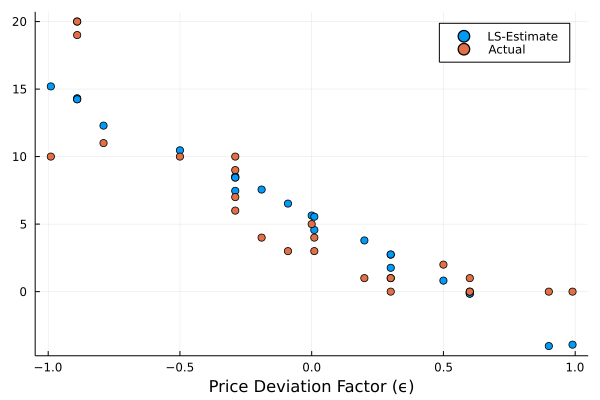

In [114]:
# compute least squares solution
y = A*x_QR

println("Actual net order flow = ", ν_ϵ')
println("\nEstimated net order flow = \n", y)

ϵ_x = A[:, 3] # x-axis, price tweak ϵ

scatter(ϵ_x, y, label="LS-Estimate", xlabel="Price Deviation Factor (ϵ)")
scatter!(ϵ_x, ν_ϵ', label="Actual")

In [115]:
# compute the variance of ν_ϵ

# online variance 
# https://www.johndcook.com/blog/standard_deviation/
# 1962 paper by B. P. Welford and
# presented in Donald Knuth’s Art of Computer Programming, Vol 2, page 232, 3rd edition.

sum_ν_init = sum(ν_ϵ)
k = length(ν_ϵ)
mean_ν_init = sum_ν_init / k

# example -
example_E_ν_ϵ = ([101.5 0.21 0.78]*x_QR)[1]
mean_ν_ϵ = mean_ν_init + ((example_E_ν_ϵ - mean_ν_init) / k)

var_ν_init = 0
var_ν_ϵ = (var_ν_init + ((example_E_ν_ϵ - mean_ν_init) * (example_E_ν_ϵ - mean_ν_ϵ))) / (k - 1)

3.4265918778081663

### Normalized spread PnL (s_ϵ) mean and variance estimates

In [116]:
# use the same example table above

# Ex. Single trading round results
println("P_t = ", P_t[1]) # empirical mid-price
println("S_ref_t = ", S_ref_t[1]) # ref spread: empirical difference between mid-price and best quote

P_t = A[:, 1]
S_ref_t = A[:, 2]
ϵ = A[:, 3]

# bid price
S_bid = round(S_ref_t[1]*(1 + ϵ[1]), digits=2)
P_bid = P_t[1] - S_bid
println("P_bid = ", round(P_bid, digits=2))

# ask price
S_ask = round(S_ref_t[1]*(1 + ϵ[1]), digits=2)
P_ask = P_t[1] + S_ask
println("P_ask = ", round(P_ask, digits=2))

# trade size
println("ν_ϵ = ", ν_ϵ[1])

# spread PnL
s_PnL = (ν_ϵ[1]*S_bid)
println("s PnL = ", s_PnL)

s_norm = (ν_ϵ[1]*S_ref_t[1]*(1 + ϵ[1])) / (S_ref_t[1])
println("normalized s = ", round(s_norm, digits=2))

# normalized spread PnL
s_ϵ = [((ν_ϵ[i]*S_ref_t[i]*(1 + ϵ[i])) / (S_ref_t[i])) for i in 1:size(A, 1)] # normalized spread PnL
s_ϵ = round.(s_ϵ, digits=2)

P_t = 99.76
S_ref_t = 0.6
P_bid = 99.75
P_ask = 99.77
ν_ϵ = 10
s PnL = 0.1
normalized s = 0.1


25-element Vector{Float64}:
 0.1
 5.0
 5.0
 0.0
 0.0
 2.2
 6.39
 3.24
 1.2
 0.0
 2.2
 7.1
 2.73
 1.3
 1.6
 2.09
 4.97
 3.03
 3.0
 0.0
 2.31
 4.26
 4.04
 1.3
 0.0

In [117]:
# compute least squares estimator for s

x_QR_s = A\s_ϵ # QR Decomposition

3-element Vector{Float64}:
  0.0236206306980751
  0.1775047642482356
 -1.420648113346125

In [118]:
# compute the expected value and variance of s_ϵ

# online variance 

sum_s_init = sum(s_ϵ)
k = length(s_ϵ)
mean_s_init = sum_s_init / k

# example -
example_E_s_ϵ = ([101.5 0.21 0.78]*x_QR_s)[1] # expected value
mean_s_ϵ = mean_s_init + ((example_E_s_ϵ - mean_s_init) / k)

var_s_init = 0
var_s_ϵ = var_s_init + ((example_E_s_ϵ - mean_s_init) * (example_E_s_ϵ - mean_s_ϵ)) / (k - 1) # variance

0.05719133659236413

## Adaptive Pricing Policy

At each time step (invocation), the adaptive market maker chooses price tweak ($\epsilon_{buy}$, $\epsilon_{sell}$) at each time step to (a) meet its market share target $\eta_{ms}$, and (b) internalize (organic risk mitigation by attracting trades that offset its inventory) by skewing its prices.

### Model Parameters

In [119]:
η_ms = 0.5 # market share target
γ = 2 # risk aversion
δ_tol = 0.05 # optimization tolerance

z = 1 # initial share inventory
k = length(s_ϵ) # num samples, same as length(ν_ϵ)

sum_s_init = sum(s_ϵ) # initial spread PnL sum (for mean)
sum_s = sum_s_init
var_s_init = 0
var_s = var_s_init

sum_ν_init = sum(ν_ϵ) # initial net order flow (for mean)
sum_ν = sum_ν_init
var_ν_init = 0
var_ν = var_ν_init;

### Example Market Conditions

In [120]:
P_t = 101.50 # current mid_price
S_ref_t = 0.21 # current ref spread
V_market = 25 # total market volume in last time invocation
S_ref_0 = 0.21; # current best spread

In [121]:
# calculate the volatility σ
num_rounds = 5
P_hist = A[:, 1]
P_rounds = Float64[]

for (index, value) in enumerate(P_hist)
    if index % num_rounds == 0
        P_rounds = push!(P_rounds, value)
    end
end

println("Price per round = ", P_rounds)

# compute log-returns
R = [log(P_rounds[i+1] / P_rounds[i]) for i in 1:(num_rounds -1)]

# mean return
Rm = sum(R) / length(R)

# calculate variance
R_var = sum((R .- Rm).^2) / (length(R) - 1)

# calculate volatility
σ = sqrt(R_var)

Price per round = [99.76, 100.05, 100.26, 100.05, 100.11]


0.0021993692142361814

### Step 1: Ensure that Market Maker adapts policy if it is getting little or no trade flow
Solve for $ϵ_{*}$ = $ϵ_{buy}$ = $ϵ_{sell}$, to achieve market share target $\eta_{ms}$ within tolerance $\delta_{tol}$

In [122]:
# compute the ϵ that gets us the closest to η_ms

ϵ_ms = Variable() # scalar
t = Variable() # scalar

# reformulate absolute value
# abs(η_ms - (([P_t S_ref_t ϵ_ms]*x_QR)[1])/V_market)
prob = η_ms - (([P_t S_ref_t ϵ_ms]*x_QR)[1]) / V_market
problem = minimize(t, ϵ_ms >= -0.02, ϵ_ms <= 0.02, t >= prob, t >= -prob)

# Solve the problem by calling solve!
solve!(problem, ECOS.Optimizer; silent_solver = true)

# Check the status of the problem (:Optimal, :Infeasible, :Unbounded etc.)
println("Status: ", problem.status)

# Get the optimum value of ϵ_ms
println("Optimum ϵ_ms = ", round.(evaluate(ϵ_ms), digits = 2))

# Get the optimum value for the minimized cost
println("Minimal Cost = ", round(problem.optval, digits = 5))

Status: OPTIMAL
Optimum ϵ_ms = -0.02
Minimal Cost = 0.32594


In [123]:
# compute expected value of ν_ϵ
function E_ν_ϵ(P_t, S_ref_t, x_QR, ϵ)
    A_ϵ = [P_t S_ref_t ϵ]
    Expected_ν_ϵ = (A_ϵ*x_QR)[1]
    return Expected_ν_ϵ
end

# manually check solution
ϵ_check = -0.02
E_ν_ϵ(P_t, S_ref_t, x_QR, ϵ_check)
cost1_check = abs(η_ms - E_ν_ϵ(P_t, S_ref_t, x_QR, ϵ_check)/V_market)

isapprox(cost1_check, problem.optval)

true

In [124]:
# compute the ϵ that maximizes profit within δ_tol

# initialize -
cost1 = problem.optval
ϵ_opt = Variable() # scalar
t = Variable() # scalar
prob = η_ms - (([P_t S_ref_t ϵ_opt]*x_QR)[1]) / V_market

# setup problem -
p = maximize(ϵ_opt)
p.constraints += prob <= t
p.constraints += -prob <= t
p.constraints += t - cost1 <= δ_tol
p.constraints += -(t - cost1) <= δ_tol

# Solve the problem by calling solve!
solve!(p, ECOS.Optimizer; silent_solver = true)

# Check the status of the problem (:Optimal, :Infeasible, :Unbounded etc.)
println("Status: ", p.status)

# Check the convergence value
println("$(δ_tol) >= ", round(((η_ms - (([P_t S_ref_t evaluate(ϵ_opt)]*x_QR)[1]) / V_market) - cost1), digits=2))

# Get the optimum value of ϵ_opt
println("ϵ_opt = $(round(p.optval, digits = 5)) => ", round(p.optval, digits = 2))

# Set buy and sell ϵ values
ϵ_buy = round(p.optval, digits = 2)
ϵ_sell = round(p.optval, digits = 2)
println("ϵ_buy = $(ϵ_buy), ϵ_sell = $(ϵ_sell)")

Status: OPTIMAL
0.05 >= 0.05
ϵ_opt = 0.10941 => 0.11
ϵ_buy = 0.11, ϵ_sell = 0.11


In [125]:
# current price quotes
P_bid = P_t - round(S_ref_0*(1 + ϵ_buy), digits=2); P_ask = P_t + round(S_ref_0*(1 + ϵ_sell), digits=2)
println("P_bid = $(P_bid), P_ask = $(P_ask)")

P_bid = 101.27, P_ask = 101.73


### Step 2: Skew one side (buy/sell) to attract a flow that offsets current inventory
Tradeoff: Loss of spread PnL vs. inventory risk

In [126]:
using JuMP
import Ipopt

# initialize -
cost2 = Model(Ipopt.Optimizer)
set_silent(cost2)
ϵ_skew = 0 # scalar
@variable(cost2, ϵ_skew)

# setup problem -
E_s_ϵ = ([P_t S_ref_t ϵ_skew]*x_QR_s)[1] # expected value
mean_s = sum_s / k
mean_s_ϵ = mean_s + ((E_s_ϵ - mean_s) / k)
var_s_ϵ = (var_s + ((E_s_ϵ - mean_s) * (E_s_ϵ - mean_s_ϵ))) # variance

E_z_ν_ϵ = z + ([P_t S_ref_t ϵ_skew]*x_QR)[1] # expected value
mean_ν = sum_ν / k
mean_z_ν_ϵ = mean_ν + ((E_z_ν_ϵ - mean_ν) / k)
var_z_ν_ϵ = (var_ν + ((E_z_ν_ϵ - mean_ν) * (E_z_ν_ϵ - mean_z_ν_ϵ))) # variance

# solve the problem -
@NLobjective(cost2, Min, -(S_ref_0 * E_s_ϵ) + γ * sqrt((S_ref_0^2 * var_s_ϵ) + (σ^2 * var_z_ν_ϵ)))
optimize!(cost2)

# Check the status of the problem
println("Status: ", termination_status(cost2))

# Check the variance values
println("var_s_ϵ = $(value.(var_s_ϵ)), var_z_ν_ϵ = $(value.(var_z_ν_ϵ))")

# Get the optimum value of ϵ_skew
println("ϵ_skew = $(round(value.(ϵ_skew), digits = 5)) => ", round(value.(ϵ_skew), digits = 2))

# Get the optimum value for the minimized cost
println("Minimal Cost = ", round(objective_value(cost2), digits = 5))

Status: LOCALLY_SOLVED
var_s_ϵ = 7.245664491381532e-7, var_z_ν_ϵ = 0.013806533305029234
ϵ_skew = -0.06229 => -0.06
Minimal Cost = -0.52926


In [127]:
if z > 0
    # positive inventory
    ϵ_buy = ϵ_buy
    ϵ_sell = round(value.(ϵ_skew), digits = 2)
    println("ϵ_buy = $(ϵ_buy), ϵ_sell = $(ϵ_sell)")
    P_bid = P_t - round(S_ref_0*(1 + ϵ_buy), digits=2); P_ask = P_t + round(S_ref_0*(1 + ϵ_sell), digits=2)
    println("P_bid = $(P_bid), P_ask = $(P_ask)")
    # SUBMIT QUOTES
    ϵ_hedge = ϵ_sell
elseif z < 0
    # negative inventory
    ϵ_buy = round(value.(ϵ_skew), digits = 2)
    ϵ_sell = ϵ_sell
    println("ϵ_buy = $(ϵ_buy), ϵ_sell = $(ϵ_sell)")
    P_bid = P_t - round(S_ref_0*(1 + ϵ_buy), digits=2); P_ask = P_t + round(S_ref_0*(1 + ϵ_sell), digits=2)
    println("P_bid = $(P_bid), P_ask = $(P_ask)")
    # SUBMIT QUOTES
    ϵ_hedge = ϵ_buy
else
    # no inventory
    ϵ_buy = ϵ_buy
    ϵ_sell = ϵ_sell
    println("ϵ_buy = $(ϵ_buy), ϵ_sell = $(ϵ_sell)")
    P_bid = P_t - round(S_ref_0*(1 + ϵ_buy), digits=2); P_ask = P_t + round(S_ref_0*(1 + ϵ_sell), digits=2)
    println("P_bid = $(P_bid), P_ask = $(P_ask)")
    # SUBMIT QUOTES
    ϵ_hedge = ϵ_buy
end;

ϵ_buy = 0.11, ϵ_sell = -0.06
P_bid = 101.27, P_ask = 101.7


### Step 3: Hedging Policy
Determine the fraction of current inventory to hedge (by initiating offsetting trade)

In [128]:
# initialize -
cost_hedge = Model(Ipopt.Optimizer)
set_silent(cost_hedge)
x_frac = 0 # scalar
Z = z # scalar
@variable(cost_hedge, 0 <= x_frac <= 1)
@variable(cost_hedge, -3000 <= Z <= 3000)

# setup problem -
Z = z*(1 - x_frac)
E_zx_ν_ϵ = Z + ([P_t S_ref_t ϵ_hedge]*x_QR)[1] # expected value
mean_ν = sum_ν / k
mean_zx_ν_ϵ = mean_ν + ((E_zx_ν_ϵ - mean_ν) / k)
var_zx_ν_ϵ = (var_ν + ((E_zx_ν_ϵ - mean_ν) * (E_zx_ν_ϵ - mean_zx_ν_ϵ))) # variance

# solve the problem -
@NLobjective(cost_hedge, Min, (abs(x_frac*z) * S_ref_0) + γ * sqrt(σ^2 * var_zx_ν_ϵ))
optimize!(cost_hedge)

# Check the status of the problem
println("Status: ", termination_status(cost_hedge))

# Check the variance values
println("var_zx_ν_ϵ = $(value.(var_zx_ν_ϵ))")

# Get the optimum value of x_frac
println("x_frac = $(round(value.(x_frac), digits = 5)) => ", round(value.(x_frac), digits = 2))

# Get the optimum value for the minimized cost
println("Minimal Cost = ", round(objective_value(cost_hedge), digits = 5))


Status: LOCALLY_SOLVED
var_zx_ν_ϵ = 0.019381354634220502
x_frac = 0.0 => 0.0
Minimal Cost = 0.00061


In [129]:
x_frac = round(value.(x_frac), digits = 2)

if z > 0
    # positive inventory
    order_size = -round(Int, (x_frac*z))
    println("Hedge sell order -> sell $(order_size) shares")
    # SUBMIT SELL MARKET ORDER
    println("Inventory z = $(z) -> z = $(z - order_size)")
    # UPDATE z
elseif z < 0
    # negative inventory
    order_size = round(Int, (x_frac*z))
    println("Hedge buy order -> buy $(order_size) shares")
    # SUBMIT BUY MARKET ORDER
    println("Inventory z = $(z) -> z = $(z - order_size)")
    # UPDATE z
end

Hedge sell order -> sell 0 shares
Inventory z = 1 -> z = 1


Then, wait $t_{freq}$ (assigned trade frequency) seconds and then cancel unfilled orders and update cash and inventory balances.

### Update Estimators: Recursive Least Squares

In [130]:
# initialize
ν_ϵ = (ν_ϵ')
ν_new = 0
s_new = 0
A_new = 0
unit_trade_size = 15

# recursive least squares w/ multiple observations
𝐏_old = inv(A' * A)

# new observation k appears
ν_new_bid = [unit_trade_size]
ν_new_ask = [unit_trade_size]
ν_new = vcat(ν_ϵ, vcat(ν_new_bid, ν_new_ask))
new_bid = [99.7 0.61 0.0]
new_ask = [99.7 0.61 0.0]
A_new = vcat(A, vcat(new_bid, new_ask))
s_new = [((ν_new[i]*A_new[:, 2][i]*(1 + A_new[:, 3][i])) / (A_new[:, 2][i])) for i in 1:size(A_new, 1)]

# update 𝐏_k
𝐏_new = 𝐏_old - 𝐏_old*A_new'*inv(I + A_new*𝐏_old*A_new')*A_new*𝐏_old

# compute 𝐊_k
𝐊_k = 𝐏_new*A_new'

# compute new estimator
x_hat = x_QR + 𝐊_k*(ν_new .- A_new*x_QR)

3×1 Matrix{Float64}:
  0.025424624723833382
  5.913676705922264
 -9.587981213996205

In [131]:
# compute loss (mse)
y_pred = A*x_QR
y_true = ν_ϵ
loss_prev = sum((y_true .- y_pred).^2) / length(y_true)
println(loss_prev)

y_pred = A_new*x_hat
y_true = ν_new
loss_new = sum((y_true .- y_pred).^2) / length(y_true)
println(loss_new)

8.375334902399612
13.720958533792084


In [132]:
# UPDATE FOLLOWING VARIABLES AND REPEAT

# P_t, V_market, S_ref_0
# z, k, sum_s, var_s, sum_ν, var_ν, σ
# ν_ϵ, s_ϵ, A, 𝐏_old